# Parts-of-Speech Tagging (POS)
(POS) tagging, the process of assigning a part-of-speech tag (Noun, Verb, Adjective...) to each word in an input text.  Tagging is difficult because some words can represent more than one part of speech at different times. They are  **Ambiguous**. Let's look at the following example: 

- The whole team played **well**. [adverb]
- You are doing **well** for yourself. [adjective]
- **Well**, this assignment took me forever to complete. [interjection]
- The **well** is dry. [noun]
- Tears were beginning to **well** in her eyes. [verb]

Distinguishing the parts-of-speech of a word in a sentence will help you better understand the meaning of a sentence. This would be critically important in search queries. Identifying the proper noun, the organization, the stock symbol, or anything similar would greatly improve everything ranging from speech recognition to search. By completing this assignment, you will: 

- Learn how parts-of-speech tagging works
- Compute the transition matrix A in a Hidden Markov Model
- Compute the transition matrix B in a Hidden Markov Model
- Compute the Viterbi algorithm 
- Compute the accuracy of your own model 


## Outline

- [0 Data Sources](#0)
- [1 POS Tagging](#1)
    - [1.1 Training](#1.1)
    - [1.2 Testing](#1.2)
- [2 Hidden Markov Models](#2)
    - [2.1 Generating Matrices](#2.1)
- [3 Viterbi Algorithm](#3)
    - [3.1 Initialization](#3.1)
    - [3.2 Viterbi Forward](#3.2)
    - [3.3 Viterbi Backward](#3.3)
- [4 Predicting on a data set](#4)

In [76]:
# Importing packages and loading in the data set 
import pandas as pd
from collections import defaultdict
import math
import numpy as np
from utils_pos import get_word_tag , preprocess , assign_unk

In [2]:
import os
print(os.getcwd())
print(os.listdir())

C:\Users\7a42b\ML_Jupyter\NLP\POS_Tagging
['.ipynb_checkpoints', 'HMM_POS.ipynb', 'hmm_vocab.txt', 'test.words', 'utils_pos.py', 'WSJ_02-21.pos', 'WSJ_24.pos', '__pycache__']


<a name='0'></a>
## Part 0: Data Sources
This assignment will use two tagged data sets collected from the **Wall Street Journal (WSJ)**. 

[Here](http://relearn.be/2015/training-common-sense/sources/software/pattern-2.6-critical-fork/docs/html/mbsp-tags.html) is an example 'tag-set' or Part of Speech designation describing the two or three letter tag and their meaning. 
- One data set (**WSJ-2_21.pos**) will be used for **training**.
- The other (**WSJ-24.pos**) for **testing**. 
- The tagged training data has been preprocessed to form a vocabulary (**hmm_vocab.txt**). 
- The words in the vocabulary are words from the training set that were used two or more times. 
- The vocabulary is augmented with a set of 'unknown word tokens', described below. 

The training set will be used to create the emission, transmission and tag counts. 

The test set (WSJ-24.pos) is read in to create `y`. 
- This contains both the test text and the true tag. 
- The test set has also been preprocessed to remove the tags to form **test_words.txt**. 
- This is read in and further processed to identify the end of sentences and handle words not in the vocabulary using functions provided in **utils_pos.py**. 
- This forms the list `prep`, the preprocessed text used to test our  POS taggers.

A POS tagger will necessarily encounter words that are not in its datasets. 
- To improve accuracy, these words are further analyzed during preprocessing to extract available hints as to their appropriate tag. 
- For example, the suffix 'ize' is a hint that the word is a verb, as in 'final-ize' or 'character-ize'. 
- A set of unknown-tokens, such as '--unk-verb--' or '--unk-noun--' will replace the unknown words in both the training and test corpus and will appear in the emission, transmission and tag data structures.


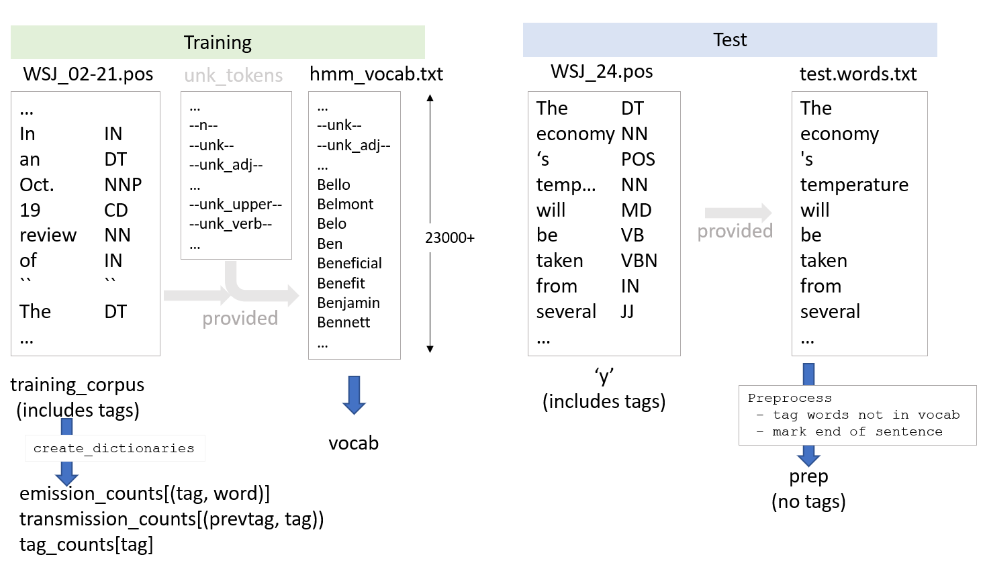

In [18]:
#This contains the words and the POS Tagged with it.
with open("WSJ_02-21.pos", 'r') as f:
    training_corpus = f.readlines()

print(f"A few items of the training corpus list")
print(training_corpus[0:10])
len(training_corpus)

A few items of the training corpus list
['In\tIN\n', 'an\tDT\n', 'Oct.\tNNP\n', '19\tCD\n', 'review\tNN\n', 'of\tIN\n', '``\t``\n', 'The\tDT\n', 'Misanthrope\tNN\n', "''\t''\n"]


989860

In [16]:
# read the vocabulary data, split by each line of text, and save the list
with open("hmm_vocab.txt", 'r') as f:
    vocab_l = f.read().split('\n')

print("A few items of the vocabulary list\n")
print(vocab_l[0:50])
print("\nA few items at the end of the vocabulary list\n")
print(vocab_l[-50:])
print(len(vocab))

A few items of the vocabulary list

['!', '#', '$', '%', '&', "'", "''", "'40s", "'60s", "'70s", "'80s", "'86", "'90s", "'N", "'S", "'d", "'em", "'ll", "'m", "'n'", "'re", "'s", "'til", "'ve", '(', ')', ',', '-', '--', '--n--', '--unk--', '--unk_adj--', '--unk_adv--', '--unk_digit--', '--unk_noun--', '--unk_punct--', '--unk_upper--', '--unk_verb--', '.', '...', '0.01', '0.0108', '0.02', '0.03', '0.05', '0.1', '0.10', '0.12', '0.13', '0.15']

A few items at the end of the vocabulary list

['yards', 'yardstick', 'year', 'year-ago', 'year-before', 'year-earlier', 'year-end', 'year-on-year', 'year-round', 'year-to-date', 'year-to-year', 'yearlong', 'yearly', 'years', 'yeast', 'yelled', 'yelling', 'yellow', 'yen', 'yes', 'yesterday', 'yet', 'yield', 'yielded', 'yielding', 'yields', 'you', 'young', 'younger', 'youngest', 'youngsters', 'your', 'yourself', 'youth', 'youthful', 'yuppie', 'yuppies', 'zero', 'zero-coupon', 'zeroing', 'zeros', 'zinc', 'zip', 'zombie', 'zone', 'zones', 'zoning', '{

In [11]:
# vocab: dictionary that has the index of the corresponding words
vocab = {} #vocab made from hmm_vocab file

# Get the index of the corresponding words. 
for i, word in enumerate(sorted(vocab_l)): 
    vocab[word] = i       
    
print("Vocabulary dictionary, key is the word, value is a unique integer")
cnt = 0
for k,v in vocab.items():
    print(f"{k} :> {v}")
    cnt += 1
    if cnt > 30:
        break

Vocabulary dictionary, key is the word, value is a unique integer
 :> 0
! :> 1
# :> 2
$ :> 3
% :> 4
& :> 5
' :> 6
'' :> 7
'40s :> 8
'60s :> 9
'70s :> 10
'80s :> 11
'86 :> 12
'90s :> 13
'N :> 14
'S :> 15
'd :> 16
'em :> 17
'll :> 18
'm :> 19
'n' :> 20
're :> 21
's :> 22
'til :> 23
've :> 24
( :> 25
) :> 26
, :> 27
- :> 28
-- :> 29
--n-- :> 30


In [12]:
# load in the test corpus same way taggesd as the train set
with open("WSJ_24.pos", 'r') as f:
    y = f.readlines()

print("A sample of the test corpus")
print(y[0:10])

A sample of the test corpus
['The\tDT\n', 'economy\tNN\n', "'s\tPOS\n", 'temperature\tNN\n', 'will\tMD\n', 'be\tVB\n', 'taken\tVBN\n', 'from\tIN\n', 'several\tJJ\n', 'vantage\tNN\n']


In [20]:
#corpus without tags , preprocessed
_, prep = preprocess(vocab, "test.words")     

print('The length of the preprocessed test corpus: ', len(prep))
print('This is a sample of the test_corpus: ')
print(prep[0:10])

The length of the preprocessed test corpus:  34199
This is a sample of the test_corpus: 
['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


<a name='1'></a>
# Part 1: Parts-of-speech tagging 

<a name='1.1'></a>
## Part 1.1 - Training
You will start with the simplest possible parts-of-speech tagger and we will build up to the state of the art. 

In this section, you will find the words that are not ambiguous. 
- For example, the word `is` is a verb and it is not ambiguous. 
- In the `WSJ` corpus, $86$% of the token are unambiguous (meaning they have only one tag) 
- About $14\%$ are ambiguous (meaning that they have more than one tag)
- But these 14% ambiguous are tend to be used more than 46% of time so hence this way is not actually very good


Before you start predicting the tags of each word, you will need to compute a few dictionaries that will help you to generate the tables. 

#### Transition counts (the a matrix)
- The first dictionary is the `transition_counts` dictionary which computes the number of times each tag happened next to another tag. 

This dictionary will be used to compute: 
$$P(t_i |t_{i-1}) \tag{1}$$

This is the probability of a tag at position $i$ given the tag at position $i-1$.

In order for you to compute equation 1, you will create a `transition_counts` dictionary where 
- The keys are `(prev_tag, tag)`
- The values are the number of times those two tags appeared in that order. 

So to predict the current words tag we use the previous words tag and make use of a transition probabilities to make the prediction

#### Emission counts (the b matrix)

The second dictionary you will compute is the `emission_counts` dictionary. This dictionary will be used to compute:

$$P(w_i|t_i)\tag{2}$$

In other words, you will use it to compute the probability of a word given its tag. 

In order for you to compute equation 2, you will create an `emission_counts` dictionary where 
- The keys are `(tag, word)` 
- The values are the number of times that pair showed up in your training set. 

#### Tag counts

The last dictionary you will compute is the `tag_counts` dictionary. 
- The key is the tag 
- The value is the number of times each tag appeared.

<a name='ex-01'></a>
### Exercise 01

**Instructions:** Write a program that takes in the `training_corpus` and returns the three dictionaries mentioned above `transition_counts`, `emission_counts`, and `tag_counts`. 
- `emission_counts`: maps (tag, word) to the number of times it happened. 
- `transition_counts`: maps (prev_tag, tag) to the number of times it has appeared. 
- `tag_counts`: maps (tag) to the number of times it has occured. 

Implementation note: This routine utilises *defaultdict*, which is a subclass of *dict*. 
- A standard Python dictionary throws a *KeyError* if you try to access an item with a key that is not currently in the dictionary. 
- In contrast, the *defaultdict* will create an item of the type of the argument, in this case an integer with the default value of 0. 
- See [defaultdict](https://docs.python.org/3.3/library/collections.html#defaultdict-objects).

### SO a small understanding not mathematical way

### Transition prop is the probability of transitioning from from one statet to the other state and hence to find that proability we will have to count to number of time we
### transitioned from state i -->j and this prob will be no of times we went from i-->j / no of times we transitioned from i

### emmision prob is the prob that if in state i then the prob of that the observation made will be Oj and for that we will like think of simply as when at the state i what output did u observe when u were here and to make it into a prob we will have to count no of time we obsered Oj when at state i / total no of state i in this 

### and note in this intial implementation we are only looking at two consecetive words and assuming that the entire corpus is one statement

HERE A DIRECT COMP TABLE -->
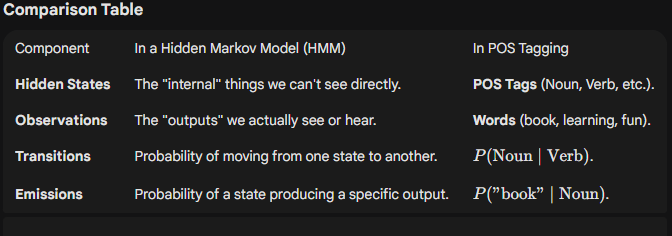

In [29]:
def create_dictionaries(training_corpus, vocab):
    """
    Input: 
        training_corpus: a corpus where each line has a word followed by its tag.
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output: 
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        transition_counts: a dictionary where the keys are (prev_tag, tag) and the values are the counts
        tag_counts: a dictionary where the keys are the tags and the values are the counts
    """
    
    # initialize the dictionaries using defaultdict
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)
    
    # Initialize "prev_tag" (previous tag) with the start state, denoted by '--s--'
    prev_tag = '--s--' 
    
    # use 'i' to track the line number in the corpus
    i = 0 
    
    # Each item in the training corpus contains a word and its POS tag
    # Go through each word and its tag in the training corpus
    for word_tag in training_corpus:
        
        # Increment the word_tag count
        i += 1
        
        # Every 50,000 words, print the word count
        if i % 50000 == 0:
            print(f"word count = {i}")

        word, tag = get_word_tag(word_tag,vocab)   #get the word and tag using the get_word_tag helper function (imported from utils_pos.py)
        
        transition_counts[(prev_tag, tag)] += 1   #Increment the transition count for the previous word and tag so we came from prev tag to this tag...so in transition count
        
        emission_counts[(tag, word)] += 1  # Increment the emission count for the tag and word so this is our emission count how many times when the wo

        tag_counts[tag] += 1  # Increment the tag count

        prev_tag = tag # Set the previous tag to this tag (for the next iteration of the loop)
        
    return emission_counts, transition_counts, tag_counts

In [26]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000


In [30]:
# get all the POS states
states = sorted(tag_counts.keys())
print(f"Number of POS tags (number of 'states'): {len(states)}")
print("View these POS tags (states)")
print(states) #note the tag_count[tag] now will give us the not of times this there was this tag state in the timeline

Number of POS tags (number of 'states'): 46
View these POS tags (states)
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


##### Expected Output

```CPP
Number of POS tags (number of 'states'46
View these states
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']
```

The 'states' are the Parts-of-speech designations found in the training data. They will also be referred to as 'tags' or POS in this assignment. 

- "NN" is noun, singular, 
- 'NNS' is noun, plural. 
- In addition, there are helpful tags like '--s--' which indicate a start of a sentence.

In [36]:
print("transition examples: ")
for ex in list(transition_counts.items())[:3]: #shows how many times we transitioned from one state to the other state i.e the POS
    print(ex)
print()

print("emission examples: ") #this was the given tag on this state and the observation made is the word which was outputted on this day
for ex in list(emission_counts.items())[200:203]:
    print (ex)
print()

print("ambiguous word example: ")
for tup,cnt in emission_counts.items():
    if tup[1] == 'back': print (tup, cnt) #we can see that based on the prev words back was tagged as many different POS 

transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('DT', 'any'), 721)
(('NN', 'decrease'), 7)
(('NN', 'insider-trading'), 5)

ambiguous word example: 
('RB', 'back') 304
('VB', 'back') 20
('RP', 'back') 84
('JJ', 'back') 25
('NN', 'back') 29
('VBP', 'back') 4


##### Expected Output

```CPP
transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('DT', 'any'), 721)
(('NN', 'decrease'), 7)
(('NN', 'insider-trading'), 5)

ambiguous word example: 
('RB', 'back') 304
('VB', 'back') 20
('RP', 'back') 84
('JJ', 'back') 25
('NN', 'back') 29
('VBP', 'back') 4
```

<a name='1.2'></a>
### Part 1.2 - Testing

Now you will test the accuracy of your parts-of-speech tagger using your `emission_counts` dictionary. 
- Given your preprocessed test corpus `prep`, you will assign a parts-of-speech tag to every word in that corpus. 
- Using the original tagged test corpus `y`, you will then compute what percent of the tags you got correct. 

<a name='ex-02'></a>
### Exercise 02

**Instructions:** Implement `predict_pos` that computes the accuracy of your model. 

- This is a warm up exercise. 
- To assign a part of speech to a word, assign the most frequent POS for that word in the training set. 
- Then evaluate how well this approach works.  Each time you predict based on the most frequent POS for the given word, check whether the actual POS of that word is the same.  If so, the prediction was correct!
- Calculate the accuracy as the number of correct predictions divided by the total number of words for which you predicted the POS tag.

y is the test dataset which cointain the words and POS tagged
pred is the is the same y but with the POS removed and now we make use of our dicitonries to predict the POS of this word and then check with y 

In [42]:
def predict_pos(prep, y, emission_counts, vocab, states):
    
    '''
    Input: 
        prep: a preprocessed version of 'y'. A list with the 'word' component of the tuples.
        y: a corpus composed of a list of tuples where each tuple consists of (word, POS)
        emission_counts: a dictionary where the keys are (tag,word) tuples and the value is the count
        vocab: a dictionary where keys are words in vocabulary and value is an index
        states: a sorted list of all possible tags for this assignment
    Output: 
        accuracy: Number of times you classified a word correctly
    '''
    
    
    num_correct = 0
    
    all_words = set(emission_counts.keys()) #Get the (tag, word) tuples, stored as a set
    
    total = len(y)
    for word, y_tup in zip(prep, y): #both are of same size

        y_tup_l = y_tup.split()  #Split the (word, POS) string into a list of two items
        
        if len(y_tup_l) == 2: # Verify that y_tup contain both word and POS
            
            true_label = y_tup_l[1] # Set the true POS label for this word

        else:
            continue #If the y_tup didn't contain word and POS, go to next word
    
        count_final = 0
        pos_final = ''
        
        # If the word is in the vocabulary...
        if word in vocab:
            for pos in states:
                        
                key = (pos,word)  # define the key as the tuple containing the POS and word
               
                if key in emission_counts:  # check if the (pos, word) key exists in the emission_counts dictionary
               
                    count = emission_counts[key]  # get the emission count of the (pos,word) tuple 

                    if count>count_final: # keep track of the POS with the largest count

                        count_final = count # update the final count (largest count)
                        pos_final = pos # update the final POS

            if pos_final == true_label:
                num_correct += 1

    accuracy = num_correct / total
    
    return accuracy

In [43]:
accuracy_predict_pos = predict_pos(prep, y, emission_counts, vocab, states)
print(f"Accuracy of prediction using predict_pos is {accuracy_predict_pos:.4f}")

Accuracy of prediction using predict_pos is 0.8889


##### Expected Output
```CPP
Accuracy of prediction using predict_pos is 0.8889
```

88.9% is really good for this warm up exercise. With hidden markov models, you should be able to get **95% accuracy.**

<a name='2'></a>
# Prat 2 : Hidden Markov Models for POS

Now you will build something more context specific. Concretely, you will be implementing a Hidden Markov Model (HMM) with a Viterbi decoder
- The HMM is one of the most commonly used algorithms in Natural Language Processing, and is a foundation to many deep learning techniques you will see in this specialization. 
- In addition to parts-of-speech tagging, HMM is used in speech recognition, speech synthesis, etc. 
- By completing this part of the assignment you will get a 95% accuracy on the same dataset you used in Part 1.

The Markov Model contains a number of states and the probability of transition between those states. 
- In this case, the states are the parts-of-speech. 
- A Markov Model utilizes a transition matrix, `A`. 
- A Hidden Markov Model adds an observation or emission matrix `B` which describes the probability of a visible observation when we are in a particular state. 
- In this case, the emissions are the words in the corpus
- The state, which is hidden, is the POS tag of that word.

Now one subtle ideal step is like from the previous method where we have the counts now we ar going to use them as probabilities

<a name='2.1'></a>
## Part 2.1 Generating Matrices

### Creating the 'A' transition probabilities matrix
Now that you have your `emission_counts`, `transition_counts`, and `tag_counts`, you will start implementing the Hidden Markov Model. 

This will allow you to quickly construct the 
- `A` transition probabilities matrix.
- and the `B` emission probabilities matrix. 

You will also use some smoothing when computing these matrices. 

Here is an example of what the `A` transition matrix would look like (it is simplified to 5 tags for viewing. It is 46x46 in this assignment.):


|A----|.|----RBS-----|-----RP-----|-----SYM----|---TO---|-----UH-----|...

| ---||---:----------|------------|------------|--------|------------|----

|RBS|...|2.217069e-06|2.217069e-06|2.217069e-06|0.008870|2.217069e-06|...

|RP |...|3.756509e-07|7.516775e-04|3.756509e-07|0.051089|3.756509e-07|...

|SYM|...|1.722772e-05|1.722772e-05|1.722772e-05|0.000017|1.722772e-05|...

|TO |...|4.477336e-05|4.472863e-08|4.472863e-08|0.000090|4.477336e-05|...

|UH |...|1.030439e-05|1.030439e-05|1.030439e-05|0.061837|3.092348e-02|...

|.........|...| ...          | ...          | ...          | ...      | ...        | ...

Note that the matrix above was computed with smoothing. 

Each cell gives you the probability to go from one part of speech to another. 
- In other words, there is a 4.47e-8 chance of going from parts-of-speech `TO` to `RP`. 
- The sum of each row has to equal 1, because we assume that the next POS tag must be one of the available columns in the table.

The smoothing was done as follows: 

$$ P(t_i | t_{i-1}) = \frac{C(t_{i-1}, t_{i}) + \alpha }{C(t_{i-1}) +\alpha * N}\tag{3}$$

- $N$ is the total number of tags
- $C(t_{i-1}, t_{i})$ is the count of the tuple (previous POS, current POS) in `transition_counts` dictionary.
- $C(t_{i-1})$ is the count of the previous POS in the `tag_counts` dictionary.
- $\alpha$ is a smoothing parameter.

<a name='ex-03'></a>
### Exercise 03

**Instructions:** Implement the `create_transition_matrix` below for all tags. Your task is to output a matrix that computes equation 3 for each cell in matrix `A`. 

### SEE ABOVE WE WERE DISCUSSING ABOUT THE TRANSITION PROABBILITIES WHAT WOULD THEY BE IF GOING FROM state i to state j now we are implementing these

In [62]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
    ''' 
    Input: 
        alpha: number used for smoothing
        tag_counts: a dictionary mapping each tag to its respective count
        transition_counts: transition count for the previous word and tag
    Output:
        A: matrix of dimension (num_tags,num_tags)
    '''
    
    all_tags = sorted(tag_counts.keys())
    num_tags = len(all_tags)
    
    # Initialize the transition matrix 'A'
    A = np.zeros((num_tags,num_tags))
    
    # Get the unique transition tuples (previous POS, current POS)
    trans_keys = set(transition_counts.keys())
    
    # Go through each row of the transition matrix A
    for i in range(num_tags):
        
        # Go through each column of the transition matrix A
        for j in range(num_tags):

            # Initialize the count of the (prev POS, current POS) to zero
            count = 0
        
            # Define the tuple (prev POS, current POS)
            # Get the tag at position i and tag at position j (from the all_tags list)
            key = (all_tags[i],all_tags[j])

            # Check if the (prev POS, current POS) tuple 
            # exists in the transition counts dictionaory
            if transition_counts: #complete this line
                
                # Get count from the transition_counts dictionary 
                # for the (prev POS, current POS) tuple
                count = transition_counts[key]
                
            # Get the count of the previous tag (index position i) from tag_counts
            count_prev_tag = tag_counts[all_tags[i]]
            
            # Apply smoothing using count of the tuple, alpha, 
            # count of previous tag, alpha, and number of total tags
            A[i,j] = (count + alpha) / (count_prev_tag + alpha*num_tags)
    
    return A #our transition matrix for the observable markov model

In [46]:
alpha = 0.001
A = create_transition_matrix(alpha, tag_counts, transition_counts)
# Testing your function
print(f"A at row 0, col 0: {A[0,0]:.9f}")
print(f"A at row 3, col 1: {A[3,1]:.4f}")

print("View a subset of transition matrix A")
A_sub = pd.DataFrame(A[30:35,30:35], index=states[30:35], columns = states[30:35] )
print(A_sub)

A at row 0, col 0: 0.000007040
A at row 3, col 1: 0.1691
View a subset of transition matrix A
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02


##### Expected Output
```CPP
A at row 0, col 0: 0.000007040
A at row 3, col 1: 0.1691
View a subset of transition matrix A
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02
```

### Create the 'B' emission probabilities matrix

Now you will create the `B` transition matrix which computes the emission probability. 

You will use smoothing as defined below: 

$$P(w_i | t_i) = \frac{C(t_i, word_i)+ \alpha}{C(t_{i}) +\alpha * N}\tag{4}$$

- $C(t_i, word_i)$ is the number of times $word_i$ was associated with $tag_i$ in the training data (stored in `emission_counts` dictionary).
- $C(t_i)$ is the number of times $tag_i$ was in the training data (stored in `tag_counts` dictionary).
- $N$ is the number of words in the vocabulary
- $\alpha$ is a smoothing parameter. 

The matrix `B` is of dimension (num_tags, N), where num_tags is the number of possible parts-of-speech tags. 

Here is an example of the matrix, only a subset of tags and words are shown: 
<p style='text-align: center;'> <b>B Emissions Probability Matrix (subset)</b>  </p>

|**B**| ...|          725 |     adroitly |    engineers |     promoted |      synergy| ...|
|----|----|--------------|--------------|--------------|--------------|-------------|----|
|**CD**  | ...| **8.201296e-05** | 2.732854e-08 | 2.732854e-08 | 2.732854e-08 | 2.732854e-08| ...|
|**NN**  | ...| 7.521128e-09 | 7.521128e-09 | 7.521128e-09 | 7.521128e-09 | **2.257091e-05**| ...|
|**NNS** | ...| 1.670013e-08 | 1.670013e-08 |**4.676203e-04** | 1.670013e-08 | 1.670013e-08| ...|
|**VB**  | ...| 3.779036e-08 | 3.779036e-08 | 3.779036e-08 | 3.779036e-08 | 3.779036e-08| ...|
|**RB**  | ...| 3.226454e-08 | **6.456135e-05** | 3.226454e-08 | 3.226454e-08 | 3.226454e-08| ...|
|**RP**  | ...| 3.723317e-07 | 3.723317e-07 | 3.723317e-07 | **3.723317e-07** | 3.723317e-07| ...|
| ...    | ...|     ...      |     ...      |     ...      |     ...      |     ...      | ...|



<a name='ex-04'></a>
### Exercise 04
**Instructions:** Implement the `create_emission_matrix` below that computes the `B` emission probabilities matrix. Your function takes in $\alpha$, the smoothing parameter, `tag_counts`, which is a dictionary mapping each tag to its respective count, the `emission_counts` dictionary where the keys are (tag, word) and the values are the counts. Your task is to output a matrix that computes equation 4 for each cell in matrix `B`. 

### SEE AGAIN AS BEFORE WE DISCUSSED THAT WE ON A TRANSITION STATE WHAT IS THE PROBABILITY OF THIS OBSERVATION BEING THE OUTPUT i.e the count of state-->with this word / cnt of this state

In [48]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    '''
    Input: 
        alpha: tuning parameter used in smoothing 
        tag_counts: a dictionary mapping each tag to its respective count
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        B: a matrix of dimension (num_tags, len(vocab))
    '''
    num_tags = len(tag_counts)
    all_tags = sorted(tag_counts.keys())
    
    # Get the total number of unique words in the vocabulary
    num_words = len(vocab)
    
    # Initialize the emission matrix B with places for ags in the rows and words in the columns
    B = np.zeros((num_tags, num_words))
    
    # Get a set of all (POS, word) tuples 
    # from the keys of the emission_counts dictionary
    emis_keys = set(list(emission_counts.keys()))
    
    # Go through each row (POS tags)
    for i in range(num_tags): # complete this line
        
        # Go through each column (words)
        for j in range(num_words): # complete this line

            # Initialize the emission count for the (POS tag, word) to zero
            count = 0
                    
            # Define the (POS tag, word) tuple for this row and column
            key =  (all_tags[i],vocab[j])

            # check if the (POS tag, word) tuple exists as a key in emission counts
            if key in emission_counts.keys(): # complete this line
        
                # Get the count of (POS tag, word) from the emission_counts d
                count = emission_counts[key]
                
            # Get the count of the POS tag
            count_tag = tag_counts[all_tags[i]]
                
            # Apply smoothing and store the smoothed value 
            # into the emission matrix B for this row and column
            B[i,j] = (count + alpha) / (count_tag+ alpha*num_words)

    return B

In [49]:
# creating your emission probability matrix. this takes a few minutes to run. 
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))

print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")

# Try viewing emissions for a few words in a sample dataframe
cidx  = ['725','adroitly','engineers', 'promoted', 'synergy']

# Get the integer ID for each word
cols = [vocab[a] for a in cidx]

# Choose POS tags to show in a sample dataframe
rvals =['CD','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags
B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
print(B_sub)

View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07


##### Expected Output

```CPP
View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07
```

<a name='3'></a>
# Part 3: Viterbi Algorithm and Dynamic Programming

In this part of the assignment you will implement the Viterbi algorithm which makes use of dynamic programming. Specifically, you will use your two matrices, `A` and `B` to compute the Viterbi algorithm. We have decomposed this process into three main steps for you. 

* **Initialization** - In this part you initialize the `best_paths` and `best_probabilities` matrices that you will be populating in `feed_forward`.
* **Feed forward** - At each step, you calculate the probability of each path happening and the best paths up to that point. 
* **Feed backward**: This allows you to find the best path with the highest probabilities. 

<a name='3.1'></a>
## Part 3.1:  Initialization 

You will start by initializing two matrices of the same dimension. 

- best_probs: Each cell contains the probability of going from one POS tag to a word in the corpus.

- best_paths: A matrix that helps you trace through the best possible path in the corpus. 

SO IN THIS IMLEMENTATION WE ARE DOING A THING WHICH IS THAT WE ARE TAKING LOG OF THE PROB VALUES WHICH IS NOT NECESSARY BUT CHANGES THE VERY LOW FLOATING VALUES INTO COMPARABLE LARGER VALUES
AND LOG IS A MONOTONIC FUNCTION SO THE SCALING WONT AFFECT THE ACTUAL REUSULTS

<a name='ex-05'></a>
### Exercise 05
**Instructions**: 
Write a program below that initializes the `best_probs` and the `best_paths` matrix. 

Both matrices will be initialized to zero except for column zero of `best_probs`.  
- Column zero of `best_probs` is initialized with the assumption that the first word of the corpus was preceded by a start token ("--s--"). 
- This allows you to reference the **A** matrix for the transition probability

Here is how to initialize column 0 of `best_probs`:
- The probability of the best path going from the start index to a given POS tag indexed by integer $i$ is denoted by $\textrm{best_probs}[s_{idx}, i]$.
- This is estimated as the probability that the start tag transitions to the POS denoted by index $i$: $\mathbf{A}[s_{idx}, i]$ AND that the POS tag denoted by $i$ emits the first word of the given corpus, which is $\mathbf{B}[i, vocab[corpus[0]]]$.
- Note that vocab[corpus[0]] refers to the first word of the corpus (the word at position 0 of the corpus). 
- **vocab** is a dictionary that returns the unique integer that refers to that particular word.

Conceptually, it looks like this:
$\textrm{best_probs}[s_{idx}, i] = \mathbf{A}[s_{idx}, i] \times \mathbf{B}[i, corpus[0] ]$


In order to avoid multiplying and storing small values on the computer, we'll take the log of the product, which becomes the sum of two logs:

$best\_probs[i,0] = log(A[s_{idx}, i]) + log(B[i, vocab[corpus[0]]$

Also, to avoid taking the log of 0 (which is defined as negative infinity), the code itself will just set $best\_probs[i,0] = float('-inf')$ when $A[s_{idx}, i] == 0$


So the implementation to initialize $best\_probs$ looks like this:

$ if A[s_{idx}, i] <> 0 : best\_probs[i,0] = log(A[s_{idx}, i]) + log(B[i, vocab[corpus[0]]])$

$ if A[s_{idx}, i] == 0 : best\_probs[i,0] = float('-inf')$

Please use [math.log](https://docs.python.org/3/library/math.html) to compute the natural logarithm.

The example below shows the initialization assuming the corpus starts with the phrase "Loss tracks upward".

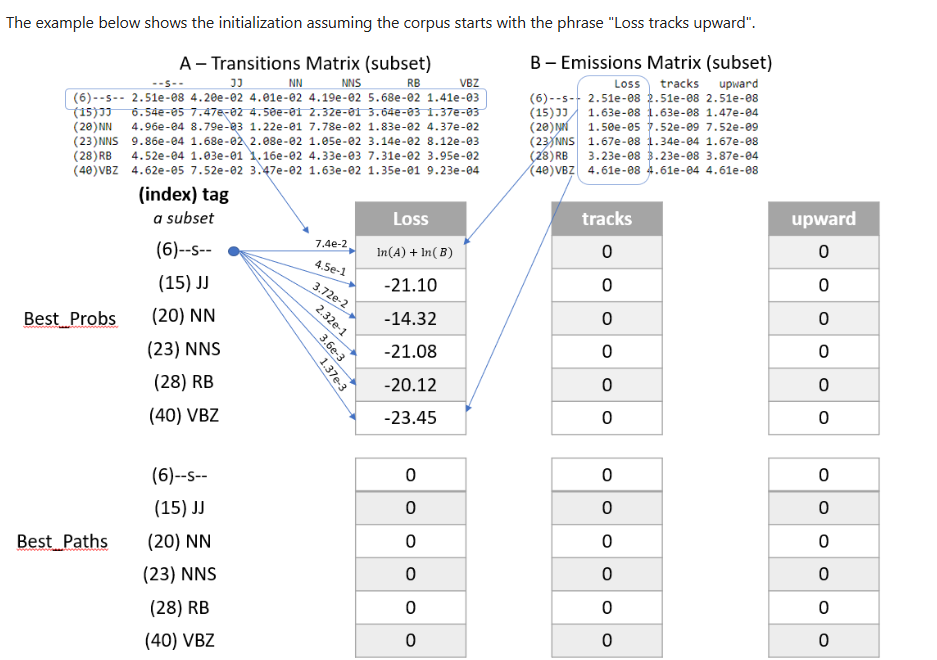

SO USING THIS WE ARE TRYING TO ANSWERT THE POINT NO 2 THAT IS WHAT SEQUENCE OF STATES BEST EXPLAINS A SEQUENCE OF OBSERVATION AND FOR THAT WE USE THE ABOVE DYNAMIX PREOGRAMMING METHOD

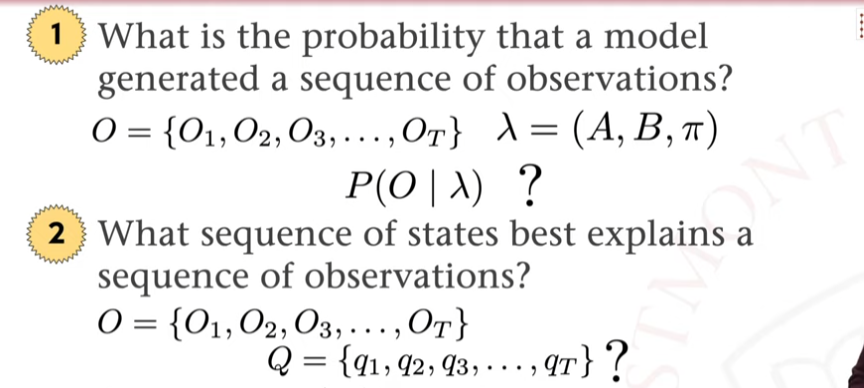

Represent infinity and negative infinity like this:

```CPP
float('inf')
float('-inf')
```

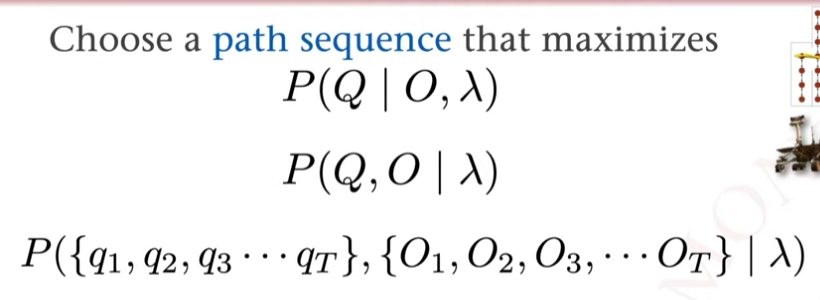

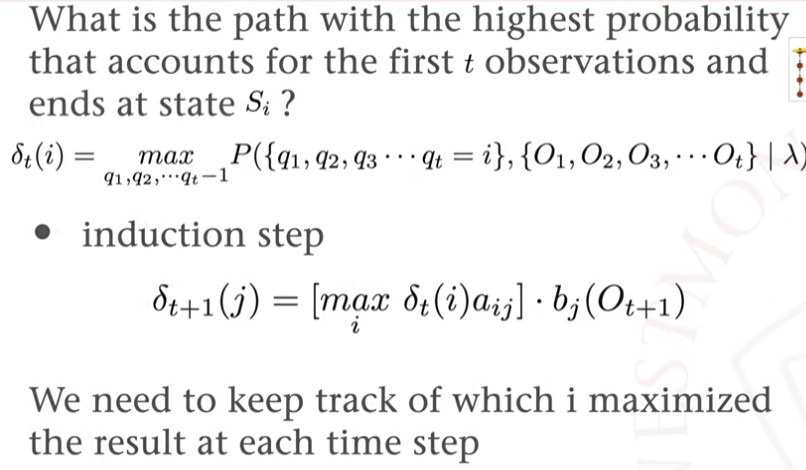

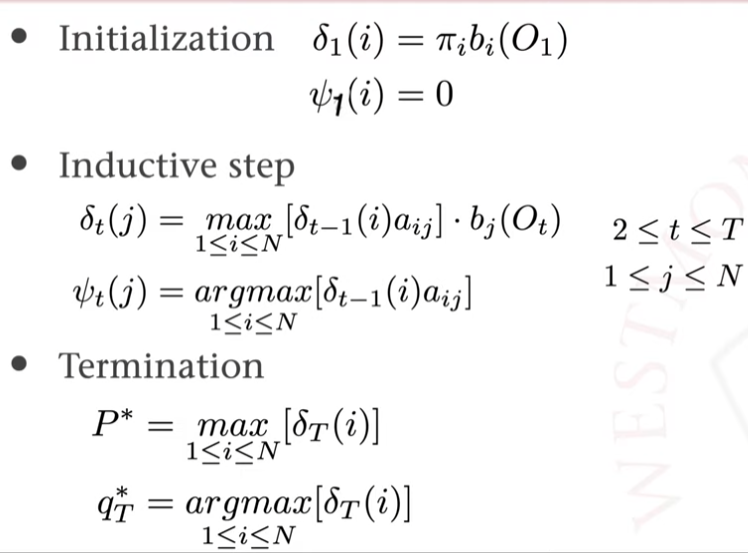

In [58]:
def initialize(states, tag_counts, A, B, corpus, vocab):
    '''
    Input: 
        states: a list of all possible parts-of-speech
        tag_counts: a dictionary mapping each tag to its respective count
        A: Transition Matrix of dimension (num_tags, num_tags)
        B: Emission Matrix of dimension (num_tags, len(vocab))
        corpus: a sequence of words whose POS is to be identified in a list 
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        best_probs: matrix of dimension (num_tags, len(corpus)) of floats
        best_paths: matrix of dimension (num_tags, len(corpus)) of integers
    '''
    num_tags = len(tag_counts)
    
    # Initialize best_probs matrix 
    # POS tags in the rows, number of words in the corpus as the columns
    best_probs = np.zeros((num_tags, len(corpus)))
    
    # Initialize best_paths matrix
    # POS tags in the rows, number of words in the corpus as columns
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int) 
    
    # Define the start token
    s_idx = states.index("--s--")
    
    # Go through each of the POS tags
    for i in range(num_tags):
        
        #special case when the transition from start token to POS tag i is zero as we do not know yet 
        if A[s_idx,i] == 0:
            best_probs[i,0] = float('-inf') # Initialize best_probs at POS tag 'i', column 0, to negative infinity
        
        # For all other cases when transition from start token to POS tag i is non-zero:
        else:
            
            # Initialize best_probs at POS tag 'i', column 0
            # Check the formula in the instructions above
            best_probs[i,0] = math.log(A[s_idx,i]) + math.log(B[i,vocab[corpus[0]]])  #mutiplied by the first observed word from the corpus
                        
    return best_probs, best_paths

In [56]:
best_probs, best_paths = initialize(states, tag_counts, A, B, prep, vocab)

In [57]:
# Test the function
print(f"best_probs[0,0]: {best_probs[0,0]:.4f}") 
print(f"best_paths[2,3]: {best_paths[2,3]:.4f}")

best_probs[0,0]: -22.6098
best_paths[2,3]: 0.0000


##### Expected Output

```CPP
best_probs[0,0]: -22.6098
best_paths[2,3]: 0.0000
```


<a name='3.2'></a>
## Part 3.2 Viterbi Forward

In this part of the assignment, you will implement the `viterbi_forward` segment. In other words, you will populate your `best_probs` and `best_paths` matrices.
- Walk forward through the corpus.
- For each word, compute a probability for each possible tag. 
- Unlike the previous algorithm `predict_pos` (the 'warm-up' exercise), this will include the path up to that (word,tag) combination. 

Here is an example with a three-word corpus "Loss tracks upward":
- Note, in this example, only a subset of states (POS tags) are shown in the diagram below, for easier reading. 
- In the diagram below, the first word "Loss" is already initialized. 
- The algorithm will compute a probability for each of the potential tags in the second and future words. 

Compute the probability that the tag of the second work ('tracks') is a verb, 3rd person singular present (VBZ).  
- In the `best_probs` matrix, go to the column of the second word ('tracks'), and row 40 (VBZ), this cell is highlighted in light orange in the diagram below.
- Examine each of the paths from the tags of the first word ('Loss') and choose the most likely path.  
- An example of the calculation for **one** of those paths is the path from ('Loss', NN) to ('tracks', VBZ).
- The log of the probability of the path up to and including the first word 'Loss' having POS tag NN is $-14.32$.  The `best_probs` matrix contains this value -14.32 in the column for 'Loss' and row for 'NN'.
- Find the probability that NN transitions to VBZ.  To find this probability, go to the `A` transition matrix, and go to the row for 'NN' and the column for 'VBZ'.  The value is $4.37e-02$, which is circled in the diagram, so add $-14.32 + log(4.37e-02)$. 
- Find the log of the probability that the tag VBS would 'emit' the word 'tracks'.  To find this, look at the 'B' emission matrix in row 'VBZ' and the column for the word 'tracks'.  The value $4.61e-04$ is circled in the diagram below.  So add $-14.32 + log(4.37e-02) + log(4.61e-04)$.
- The sum of $-14.32 + log(4.37e-02) + log(4.61e-04)$ is $-25.13$. Store $-25.13$ in the `best_probs` matrix at row 'VBZ' and column 'tracks' (as seen in the cell that is highlighted in light orange in the diagram).
- All other paths in best_probs are calculated.  Notice that $-25.13$ is greater than all of the other values in column 'tracks' of matrix `best_probs`, and so the most likely path to 'VBZ' is from 'NN'.  'NN' is in row 20 of the `best_probs` matrix, so $20$ is the most likely path.
- Store the most likely path $20$ in the `best_paths` table.  This is highlighted in light orange in the diagram below.

The formula to compute the probability and path for the $i^{th}$ word in the $corpus$, the prior word $i-1$ in the corpus, current POS tag $j$, and previous POS tag $k$ is:

$\mathrm{prob} = \mathbf{best\_prob}_{k, i-1} + \mathrm{log}(\mathbf{A}_{k, j}) + \mathrm{log}(\mathbf{B}_{j, vocab(corpus_{i})})$

where $corpus_{i}$ is the word in the corpus at index $i$, and $vocab$ is the dictionary that gets the unique integer that represents a given word.

$\mathrm{path} = k$

where $k$ is the integer representing the previous POS tag.


<a name='ex-06'></a>

### Exercise 06

Instructions: Implement the `viterbi_forward` algorithm and store the best_path and best_prob for every possible tag for each word in the matrices `best_probs` and `best_tags` using the pseudo code below.

`for each word in the corpus

    for each POS tag type that this word may be
    
        for POS tag type that the previous word could be
        
            compute the probability that the previous word had a given POS tag, that the current word has a given POS tag, and that the POS tag would emit this current word.
            
            retain the highest probability computed for the current word
            
            set best_probs to this highest probability
            
            set best_paths to the index 'k', representing the POS tag of the previous word which produced the highest probability `

Please use [math.log](https://docs.python.org/3/library/math.html) to compute the natural logarithm.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Remember that when accessing emission matrix B, the column index is the unique integer ID associated with the word.  It can be accessed by using the 'vocab' dictionary, where the key is the word, and the value is the unique integer ID for that word.</li>
</ul>
</p>


In [63]:
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab):
    '''
    Input:
        A, B: The transiton and emission matrices respectively
        test_corpus: a list containing a preprocessed corpus
        best_probs: an initilized matrix of dimension (num_tags, len(corpus))
        best_paths: an initilized matrix of dimension (num_tags, len(corpus))
        vocab: a dictionary where keys are words in vocabulary and value is an index 
    Output:
        best_probs: a completed matrix of dimension (num_tags, len(corpus))
        best_paths: a completed matrix of dimension (num_tags, len(corpus))
    '''
    num_tags = best_probs.shape[0]
    
    # Go through every word in the corpus starting from word 1
    # Recall that word 0 was initialized in `initialize()`
    for i in range(1, len(test_corpus)): 
        
        # Print number of words processed, every 5000 words
        if i % 5000 == 0:
            print("Words processed: {:>8}".format(i))
            
        # For each unique POS tag that the current word can be
        for j in range(num_tags): 
            
            best_prob_i = float("-inf") # Initialize best_prob for word i to negative infinity --->observation
            best_path_i = None # Initialize best_path for current word i to None -->state

            # For each POS tag that the previous word can be:
            for k in range(num_tags):
# Calculate the probability = best probs of POS tag k, previous word i-1 + log(prob of transition from POS k to POS j) +  log(prob that emission of POS j is word i)
                #this is the induction step
                prob = best_probs[k,i-1]+math.log(A[k,j]) +math.log(B[j,vocab[test_corpus[i]]])

                # check if this path's probability is greater than  the best probability up to and before this point
                if prob > best_prob_i:
                    best_prob_i = prob
                    
                    # keep track of the POS tag of the previous word that is part of the best path.Save the index (integer) associated with that previous word's POS tag
                    best_path_i = k

            # Save the best probability for the given current word's POS tag and the position of the current word inside the corpus
            best_probs[j,i] = best_prob_i
            
            # Save the unique integer ID of the previous POS tag into best_paths matrix, for the POS tag of the current word and the position of the current word inside the corpus.
            best_paths[j,i] = best_path_i

    return best_probs, best_paths

Run the `viterbi_forward` function to fill in the `best_probs` and `best_paths` matrices.

**Note** that this will take a few minutes to run.  There are about 30,000 words to process.

In [64]:
# this will take a few minutes to run => processes ~ 30,000 words
best_probs, best_paths = viterbi_forward(A, B, prep, best_probs, best_paths, vocab)

Words processed:     5000
Words processed:    10000
Words processed:    15000
Words processed:    20000
Words processed:    25000
Words processed:    30000


In [65]:
# Test this function 
print(f"best_probs[0,1]: {best_probs[0,1]:.4f}") 
print(f"best_probs[0,4]: {best_probs[0,4]:.4f}") 

best_probs[0,1]: -24.7822
best_probs[0,4]: -49.5601


##### Expected Output

```CPP
best_probs[0,1]: -24.7822
best_probs[0,4]: -49.5601
```

<a name='3.3'></a>
## Part 3.3 Viterbi backward

Now you will implement the Viterbi backward algorithm.
- The Viterbi backward algorithm gets the predictions of the POS tags for each word in the corpus using the `best_paths` and the `best_probs` matrices.

The example below shows how to walk backwards through the best_paths matrix to get the POS tags of each word in the corpus. Recall that this example corpus has three words: "Loss tracks upward".

POS tag for 'upward' is `RB`
- Select the the most likely POS tag for the last word in the corpus, 'upward' in the `best_prob` table.
- Look for the row in the column for 'upward' that has the largest probability.
- Notice that in row 28 of `best_probs`, the estimated probability is -34.99, which is larger than the other values in the column.  So the most likely POS tag for 'upward' is `RB` an adverb, at row 28 of `best_prob`. 
- The variable `z` is an array that stores the unique integer ID of the predicted POS tags for each word in the corpus.  In array z, at position 2, store the value 28 to indicate that the word 'upward' (at index 2 in the corpus), most likely has the POS tag associated with unique ID 28 (which is `RB`).
- The variable `pred` contains the POS tags in string form.  So `pred` at index 2 stores the string `RB`.


POS tag for 'tracks' is `VBZ`
- The next step is to go backward one word in the corpus ('tracks').  Since the most likely POS tag for 'upward' is `RB`, which is uniquely identified by integer ID 28, go to the `best_paths` matrix in column 2, row 28.  The value stored in `best_paths`, column 2, row 28 indicates the unique ID of the POS tag of the previous word.  In this case, the value stored here is 40, which is the unique ID for POS tag `VBZ` (verb, 3rd person singular present).
- So the previous word at index 1 of the corpus ('tracks'), most likely has the POS tag with unique ID 40, which is `VBZ`.
- In array `z`, store the value 40 at position 1, and for array `pred`, store the string `VBZ` to indicate that the word 'tracks' most likely has POS tag `VBZ`.

POS tag for 'Loss' is `NN`
- In `best_paths` at column 1, the unique ID stored at row 40 is 20.  20 is the unique ID for POS tag `NN`.
- In array `z` at position 0, store 20.  In array `pred` at position 0, store `NN`.

<a name='ex-07'></a>
### Exercise 07
Implement the `viterbi_backward` algorithm, which returns a list of predicted POS tags for each word in the corpus.

- Note that the numbering of the index positions starts at 0 and not 1. 
- `m` is the number of words in the corpus.  
    - So the indexing into the corpus goes from `0` to `m - 1`.
    - Also, the columns in `best_probs` and `best_paths` are indexed from `0` to `m - 1`


**In Step 1:**       
Loop through all the rows (POS tags) in the last entry of `best_probs` and find the row (POS tag) with the maximum value.
Convert the unique integer ID to a tag (a string representation) using the dictionary `states`.  

Referring to the three-word corpus described above:
- `z[2] = 28`: For the word 'upward' at position 2 in the corpus, the POS tag ID is 28.  Store 28 in `z` at position 2.
- states(28) is 'RB': The POS tag ID 28 refers to the POS tag 'RB'.
- `pred[2] = 'RB'`: In array `pred`, store the POS tag for the word 'upward'.

**In Step 2:**  
- Starting at the last column of best_paths, use `best_probs` to find the most likely POS tag for the last word in the corpus.
- Then use `best_paths` to find the most likely POS tag for the previous word. 
- Update the POS tag for each word in `z` and in `preds`.

Referring to the three-word example from above, read best_paths at column 2 and fill in z at position 1.  
`z[1] = best_paths[z[2],2]`  

The small test following the routine prints the last few words of the corpus and their states to aid in debug.

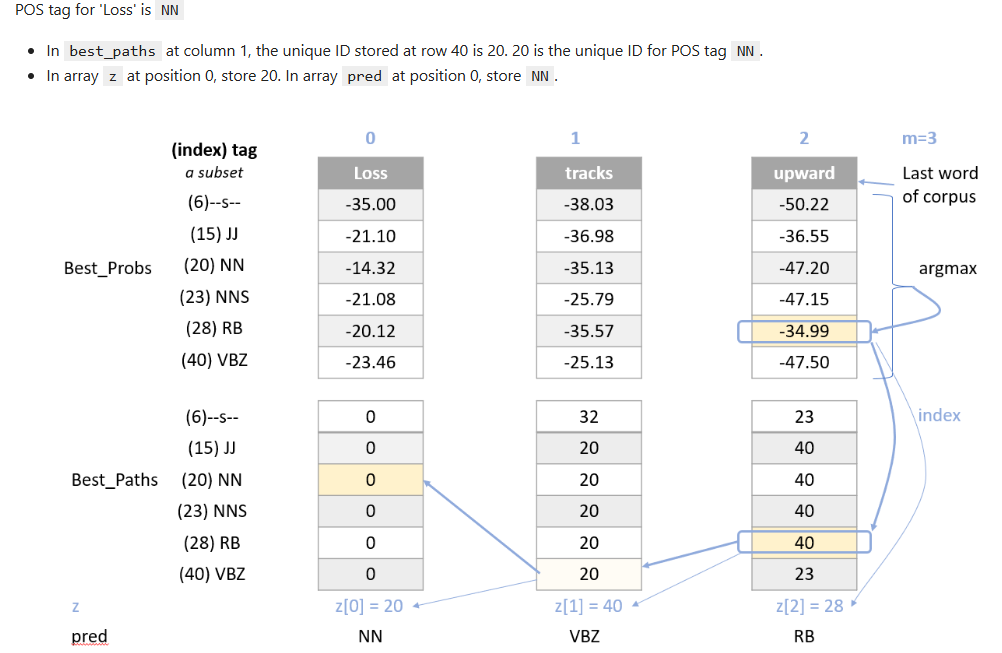

In [66]:
def viterbi_backward(best_probs, best_paths, corpus, states):
    '''
    This function returns the best path.
    '''
    # Get the number of words in the corpus which is also the number of columns in best_probs, best_paths
    m = best_paths.shape[1] #no of words in the corpus
    
    # Initialize array z, same length as the corpus
    z = [None] * m
    
    # Get the number of unique POS tags
    num_tags = best_probs.shape[0]
    
    
    best_prob_for_last_word = float('-inf') # Initialize the best probability for the last word
    
    pred = [None] * m # Initialize pred array, same length as corpus

    ## Step 1 ##
    # Go through each POS tag for the last word (last column of best_probs) in order to find the row (POS tag integer ID) with highest probability for the last word
    for k in range(num_tags):
        # If the probability of POS tag at row k is better than the previosly best probability for the last word:
        if best_probs[k,-1]>best_prob_for_last_word:
            best_prob_for_last_word = best_probs[k,-1] # Store the new best probability for the last word
            z[m - 1] = k # Store the unique integer ID of the POS tag i.e the row number 
            
    # Convert the last word's predicted POS tag
    pred[m - 1] = states[k]
    
    ## Step 2 ##
    # Find the best POS tags by walking backward through the best_paths From the last word in the corpus to the 0th word in the corpus
    for i in range(len(corpus)-1, -1, -1):
        
        # Retrieve the unique integer ID of the POS tag for the word at position 'i' in the corpus
        pos_tag_for_word_i = best_paths[np.argmax(best_probs[:,i]),i] # will get the best row nuumber from argmax and the column is i i.e the timestep
        
        # In best_paths, go to the row representing the POS tag of word i
        # and the column representing the word's position in the corpus to retrieve the predicted POS for the word at position i-1 in the corpus
        z[i - 1] = best_paths[pos_tag_for_word_i,i]
        
        #get the tag from states dic
        pred[i - 1] = states[pos_tag_for_word_i]
        
    return pred

In [67]:
# Run and test your function
pred = viterbi_backward(best_probs, best_paths, prep, states)
m=len(pred)
print('The prediction for pred[-7:m-1] is: \n', prep[-7:m-1], "\n", pred[-7:m-1], "\n")
print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", prep[0:7])

The prediction for pred[-7:m-1] is: 
 ['see', 'them', 'here', 'with', 'us', '.'] 
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.'] 

The prediction for pred[0:8] is: 
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN'] 
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken']


NOTHING SPECIAL DONE HERE THE PROBABILITIES WE HAVE STORED IN THE FORWARD STEP JUST TAKING THE HIGHEST ONE FROM THERE AND STORING THE MAX ONE IN IT AS OUR "PATH"

**Expected Output:**   

```CPP
The prediction for prep[-7:m-1] is:  
 ['see', 'them', 'here', 'with', 'us', '.']  
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.']   
The prediction for pred[0:8] is:    
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN']   
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken'] 
```

Now you just have to compare the predicted labels to the true labels to evaluate your model on the accuracy metric!

<a name='4'></a>
# Part 4: Predicting on a data set

Compute the accuracy of your prediction by comparing it with the true `y` labels. 
- `pred` is a list of predicted POS tags corresponding to the words of the `test_corpus`. 

In [70]:
print('The third word is:', prep[1979])
print('Your prediction is:', pred[1979])
print('Your corresponding label y is: ', y[1979])

The third word is: Mr.
Your prediction is: NNP
Your corresponding label y is:  Mr.	NNP



<a name='ex-08'></a>
### Exercise 08

Implement a function to compute the accuracy of the viterbi algorithm's POS tag predictions.
- To split y into the word and its tag you can use `y.split()`. 

In [71]:
def compute_accuracy(pred, y):
    '''
    Input: 
        pred: a list of the predicted parts-of-speech 
        y: a list of lines where each word is separated by a '\t' (i.e. word \t tag)
    Output: 
        
    '''
    num_correct = 0
    total = 0
    
    # Zip together the prediction and the labels
    for prediction, y in zip(pred, y):
        # Split the label into the word and the POS tag
        word_tag_tuple = y.split()
        
        # Check that there is actually a word and a tag
        # no more and no less than 2 items
        if len(word_tag_tuple)!=2: # complete this line
            continue 

        # store the word and tag separately
        word, tag = word_tag_tuple
        
        # Check if the POS tag label matches the prediction
        if prediction == tag: # complete this line
            
            # count the number of times that the prediction
            # and label match
            num_correct += 1
            
        # keep track of the total number of examples (that have valid labels)
        total += 1
        
    #Accuracy
    return num_correct/total

In [72]:
print(f"Accuracy of the Viterbi algorithm is {compute_accuracy(pred, y):.4f}")

Accuracy of the Viterbi algorithm is 0.9528


##### Expected Output

```CPP
Accuracy of the Viterbi algorithm is 0.9531
```

Congratulations you were able to classify the parts-of-speech with 95% accuracy. 

In [77]:
def test_user_input(sentence, vocab, emission_counts):
    # 1. Preprocess the input string into a list of words
    words = sentence.split()
    
    # 2. Get the prediction using the 'Most Frequent Tag' logic (Simple Tagger)
    # We use a placeholder for the labels since we'll provide them manually for accuracy
    preds = []
    for word in words:
        # Assign 'unknown' token if word not in vocab
        # (This mimics the preprocessing done in part 1.1)
        test_word = word if word in vocab else assign_unk(word)
        
        # Logic from Part 1.2: Find tag with max emission count for this word
        count_max = 0
        best_tag = ""
        
        # Iterate through all tags to find the best one for this word
        # Note: You can also use a pre-calculated dictionary for this
        for key in emission_counts.keys():
            tag, w = key
            if w == test_word:
                if emission_counts[key] > count_max:
                    count_max = emission_counts[key]
                    best_tag = tag
        preds.append(best_tag)
    
    return words, preds

In [82]:
user_input = "Humpty Dumpty Sat on a Wall and his mother went to a shopping mall while his father was at the cinema hall but there was no network so he couldn't make a call"
words, predicted_tags = test_user_input(user_input, vocab, emission_counts)

print("\n--- RESULTS ---")
for w, t in zip(words, predicted_tags):
    print(f"Word: {w:15} Predicted Tag: {t}")


--- RESULTS ---
Word: Humpty          Predicted Tag: NNP
Word: Dumpty          Predicted Tag: NNP
Word: Sat             Predicted Tag: NNP
Word: on              Predicted Tag: IN
Word: a               Predicted Tag: DT
Word: Wall            Predicted Tag: NNP
Word: and             Predicted Tag: CC
Word: his             Predicted Tag: PRP$
Word: mother          Predicted Tag: NN
Word: went            Predicted Tag: VBD
Word: to              Predicted Tag: TO
Word: a               Predicted Tag: DT
Word: shopping        Predicted Tag: NN
Word: mall            Predicted Tag: NN
Word: while           Predicted Tag: IN
Word: his             Predicted Tag: PRP$
Word: father          Predicted Tag: NN
Word: was             Predicted Tag: VBD
Word: at              Predicted Tag: IN
Word: the             Predicted Tag: DT
Word: cinema          Predicted Tag: NN
Word: hall            Predicted Tag: NN
Word: but             Predicted Tag: CC
Word: there           Predicted Tag: EX
Word: was    

In [80]:
def test_user_input_with_details(sentence, vocab, emission_counts):
    words = sentence.split()
    preds = []
    all_actual_tags = [] # To store list of possible tags for each word
    
    for word in words:
        # 1. Handle Unknowns
        test_word = word if word in vocab else assign_unk(word)
        
        # 2. Logic to find the best tag and collect all possible tags
        count_max = 0
        best_tag = ""
        possible_tags_for_this_word = []
        
        # Iterate through emission_counts to find every tag associated with this word
        for (tag, w), count in emission_counts.items():
            if w == test_word:
                possible_tags_for_this_word.append(f"{tag}({count})")
                if count > count_max:
                    count_max = count
                    best_tag = tag
        
        preds.append(best_tag)
        # If the word wasn't found at all (shouldn't happen with assign_unk), mark as empty
        all_actual_tags.append(", ".join(possible_tags_for_this_word) if possible_tags_for_this_word else "None")
    
    return words, preds, all_actual_tags

In [81]:
user_input = input("Enter a sentence to test: ")
words, predicted_tags, actual_tag_distributions = test_user_input_with_details(user_input, vocab, emission_counts)

print("\n" + "="*80)
print(f"{'WORD':<15} | {'PREDICTED':<12} | {'ACTUAL TAGS IN DICTIONARY (COUNT)':<30}")
print("-" * 80)
for w, p, actuals in zip(words, predicted_tags, actual_tag_distributions):
    print(f"{w:<15} | {p:<12} | {actuals}")
print("="*80)

Enter a sentence to test:  Humpty Dumpty Sat on a Wall and his mother went to a shopping mall while his father was at the cinema hall but there was not network so he couldn't make a call



WORD            | PREDICTED    | ACTUAL TAGS IN DICTIONARY (COUNT)
--------------------------------------------------------------------------------
Humpty          | NNP          | VBN(93), NNS(350), NNP(4635), NNPS(198), NN(365), JJ(244), PRP(5), VBG(154), VBZ(44), JJS(3), RB(79), VBD(33), PRP$(1), VB(68), JJR(4), VBP(15), WDT(2), FW(12), CD(5), IN(13), UH(10), MD(2), RBR(1), DT(2), WRB(1), RBS(1)
Dumpty          | NNP          | VBN(93), NNS(350), NNP(4635), NNPS(198), NN(365), JJ(244), PRP(5), VBG(154), VBZ(44), JJS(3), RB(79), VBD(33), PRP$(1), VB(68), JJR(4), VBP(15), WDT(2), FW(12), CD(5), IN(13), UH(10), MD(2), RBR(1), DT(2), WRB(1), RBS(1)
Sat             | NNP          | VBN(93), NNS(350), NNP(4635), NNPS(198), NN(365), JJ(244), PRP(5), VBG(154), VBZ(44), JJS(3), RB(79), VBD(33), PRP$(1), VB(68), JJR(4), VBP(15), WDT(2), FW(12), CD(5), IN(13), UH(10), MD(2), RBR(1), DT(2), WRB(1), RBS(1)
on              | IN           | IN(4996), RB(33), RP(116)
a               | DT          

### Key Points and overview

In this assignment you learned about parts-of-speech tagging. 
- In this assignment, you predicted POS tags by walking forward through a corpus and knowing the previous word.
- There are other implementations that use bidirectional POS tagging.
- Bidirectional POS tagging requires knowing the previous word and the next word in the corpus when predicting the current word's POS tag.
- Bidirectional POS tagging would tell you more about the POS instead of just knowing the previous word. 
- Since you have learned to implement the unidirectional approach, you have the foundation to implement other POS taggers used in industry.

### References

- ["Speech and Language Processing", Dan Jurafsky and James H. Martin](https://web.stanford.edu/~jurafsky/slp3/)
- We would like to thank Melanie Tosik for her help and inspiration

### SO IN ADDITION TO THIS ALGORITHM WE ALSO HAVE THE FORWARDS BACKWARD ALGORTIHM WHICH CONSIDERES THE PROBABILITY OF BEING IN THIS STATE BASED ON ALL THE PREVIOUS STATE AND GIVEN THE CURRENT STATES THE FUTURE STATES WHAT WERE THEY

ADD THE FORWARD - BACKWARD ALGORIHTM AS WELL WITH THE BAUMNA_WELCH ALGORITHM AS WELL IN THESE


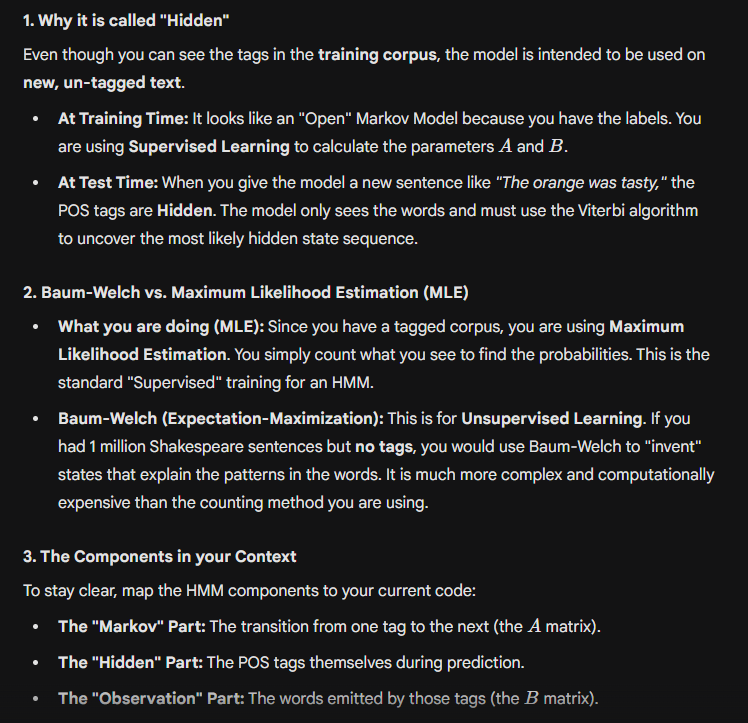

https://www.youtube.com/watch?v=JRsdt05pMoI&list=PLix7MmR3doRo3NGNzrq48FItR3TDyuLCo&index=12

BEST RESOURCE TO UNDERSTAND THE FW_BW AND BAUM ALGO